INSTALLING THE REQUIRED MODULES

In [1]:
%%bash
pip3 install gymnasium[classic_control] #Importing gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 13.9 MB/s eta 0:00:00


In [2]:
%%bash
# Installing swig before installing gymnasium[box2d]
apt-get install -y swig
pip install -U gymnasium[box2d] # Installing Gymnasium with Box2D support

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (1,009 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 123634 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubuntu1_all.deb ..

In [3]:
# Uninstalling the existing PyTorch installation:
!pip uninstall -y torch torchvision torchaudio

# Installing PyTorch with MPS support:
!pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cpu

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Found existing installation: torchaudio 2.5.1+cu121
Uninstalling torchaudio-2.5.1+cu121:
  Successfully uninstalled torchaudio-2.5.1+cu121
Looking in indexes: https://download.pytorch.org/whl/nightly/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 MB 5.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5

IMPORTING MODULES

In [26]:
#Importing the required modules
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

SETTING UP THE LUNAR LANDER ENVIRONMENT

In [27]:
#Making an environment for the lunar lander and using discrete actions instead of continuous and setting the gravitational constant and removing wind effects
env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0, enable_wind=False)
#Setting up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
  from IPython import display
plt.ion()
#Using GPU
device = torch.device(
    "cuda" if torch.cuda.is_available() else #Using CPU as MPS is showing some error
    "cpu"
)

SETTING UP THE REPLAY MEMORY

In [28]:
#Setting up Experience Replay for training the DQN
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
#A named tuple representing a single transitiion in the environment from one screen image to the other mapping initial state, action to next state and reward
class ReplayMemory(object):
#Creating a class to store and retrieve the experiences
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    #Function to initialise the replay memory using a deque for easy appending and removing and setting the max buffer size of the deque as the capacity
    def push(self, *args):
        self.memory.append(Transition(*args))
    #Function to add a transitiion to the replay memory deque as an experience
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    #Returning a random collection of batch-size items from the replay memory for training
    def __len__(self):
        return len(self.memory)
    #Returning the current number of stored experiences in the deque

SETTING UP THE NEURAL NETWORK CLASS

In [29]:
class DQN(nn.Module):
#Using DQN which is a subclass of the nn.Module in pytorch
    def __init__(self, n_observations, n_actions): #Constructor initialising the neural network layers with n_observation input neurons and n_actions output neurons
        super(DQN, self).__init__() #Explicitly calling the DQN subclass
        self.layer1 = nn.Linear(n_observations, 128) #Creating input layer and mapping it to 128 dimensional space
        self.layer2 = nn.Linear(128, 128) #Creating a middle layer
        self.layer3 = nn.Linear(128, n_actions) #Creating an output layer with n_actions output neurons

    def forward(self, x): #Function for passing the neurons through the neural network
        x = F.relu(self.layer1(x)) #Applies ReLU function then passes through layer 1
        x = F.relu(self.layer2(x)) #Applies ReLU function then passes through layer 2
        return self.layer3(x) #Returns with no activation function

INITIALISING THE HYPER PARAMETERS, SETTING UP AN ACTION SELECTION POLICY USING THE EPSILON GREEDY POLICY AND SETTING UP THE PLOT FUNCTION


In [30]:
BATCH_SIZE = 128 #Number of transititions from the replay buffer
GAMMA = 0.99 #Discount factor
EPS_START = 0.9 #Initial value of epsilon
EPS_END = 0.05 #Final value of epsilon
EPS_DECAY = 1000 #Rate of exponential decay of epsilon
TAU = 0.005 #Update rate of target network
LR = 1e-4 #Learning rate of optimiser

n_actions = env.action_space.n # Get number of actions from gym action space
state, info = env.reset()# Get the number of state observations
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device) #Initialising the policy network
target_net = DQN(n_observations, n_actions).to(device) #Initialising the target network
target_net.load_state_dict(policy_net.state_dict()) #Applying the same weights and bias to the target network

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)#Initialising the optimiser
memory = ReplayMemory(10000) #Sampling memory from the replaymemory


steps_done = 0 #Variable for number of steps


def select_action(state):#Implementing an epsilon greedy policy
    global steps_done
    sample = random.random() #Generating a random number
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY) #Setting the value of epsilon
    steps_done += 1 #Increasing number of steps
    if sample > eps_threshold: #If random number greater than epsilon then exploitation
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1) #Returning transition for maximum reward
    else: #If epsilon less than random number then exploration
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long) #Choosing a random action from the action space


episode_rewards = [] #Tracks the length of each episode


def plot_rewards(show_result=False): #Plotting the episode durations
    plt.figure(1)
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float) #Plots the duration of each episode to visualise
    if show_result: #Title if training is done
        plt.title('Result')
    else: #If training is not done
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards_t.numpy())
    # Take 100 episode averages and plot them too as a moving average
    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    #Updating the plot dynamically during the training
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

CREATING THE OPTIMISER

In [31]:
#Optimizing the model using the replay buffer
def optimize_model():
    if len(memory) < BATCH_SIZE: #There must be enough experiences in the replay buffer for it to run
        return
    transitions = memory.sample(BATCH_SIZE)#Samples random experiences from the replay buffer
    batch = Transition(*zip(*transitions)) #Creates it to a named tuple for easier processing

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool) #Checks if the next state is terminal state
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None]) #Concatenates all the non terminal next state tensors into a single tensor for easier processing
    #Extracting and concantenating the states, actions and rewards for easier processing
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    #Computing Q values for the actions taken during the sampled transition states for the current states
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device) #Computing the maximum Q value for each non terminal next state and terminal states are set to 0 by default
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values using Bellmans Equation
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

TRAINING THE MODEL

Complete


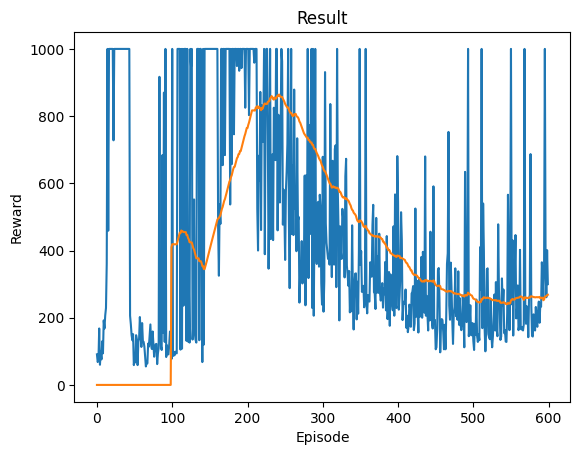

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Largest reward: 1000


In [32]:
num_episodes = 600 #Setting the number of episodes to 600
for i_episode in range(num_episodes):
    state, info = env.reset() #Resetting the environment for each episode
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0) #Creating a pytorch tensor from the initial state
    total_reward = 0 #Initialising the total reward for each episode
    for t in count(): #Runs until terminated or truncated
        action = select_action(state) #Selects an action using the epsilon greedy policy
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        total_reward += reward.item()
        done = terminated or truncated
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_rewards.append(t + 1)
            plot_rewards()
            break

print('Complete')
plot_rewards(show_result=True)
plt.ioff()
plt.show()
largest = max(episode_rewards)
print("Largest reward:", largest)

GETTING THE VIDEO OF THE MODEL

In [33]:
import glob
import io
import base64
import imageio
from IPython.display import HTML, display
from gym.wrappers.monitoring.video_recorder import VideoRecorder

def show_video_of_model(agent, env_name):
    env = gym.make(env_name, render_mode='rgb_array')
    state, _ = env.reset()
    done = False
    frames = []
    while not done:
        frame = env.render()
        frames.append(frame)
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        action = select_action((state_tensor))
        state, reward, done, _, _ = env.step(action.item())
    env.close()
    imageio.mimsave('video.mp4', frames, fps=30)

show_video_of_model(policy_net, 'LunarLander-v3')

def show_video():
    mp4list = glob.glob('*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

show_video()